# Final Test-Set Evaluation Notebook

In [17]:
# Imports
import time
import pandas as pd
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

## Loading in Training Data

In [2]:
torch.manual_seed(123)
np.random.seed(123)

train_df = pd.read_parquet("../data/training_data.parquet")

# map labels to ints
classes = sorted(train_df["label"].unique())
label2idx = {c: i for i, c in enumerate(classes)}

train_df["y"] = train_df["label"].map(label2idx)

X = train_df.filter(like="pixel_").to_numpy().astype(np.float32)
y = train_df["y"].to_numpy().astype(np.int64)
# Arrays to tensors
X = torch.from_numpy(X)
y = torch.from_numpy(y)

print(f"Features shape: {tuple(X.shape)}, Labels shape: {tuple(y.shape)}\n")
print("Classes:")
for idx, label in enumerate(classes):
    print(f"{idx} -> {label}")

Features shape: (68250, 784), Labels shape: (68250,)

Classes:
0 -> airplane
1 -> ice cream
2 -> spreadsheet
3 -> sword


## Defining the model

In [3]:
class MyModel(nn.Module):
    def __init__(self, h1, h2, dropout):
        super().__init__()

        # Fully connected layers
        self.fc1 = nn.Linear(784, h1) # 784 input features (28x28 image flattened)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, 4)   # 4 output classes

        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.relu(self.fc2(x))
        x = self.dropout(x) 

        x = self.fc3(x)
        return x

### Best Hyperparameters 

In [6]:
hparams = {
    "lr": 1e-4,
    "weight_decay": 1e-4,
    "dropout": 0.4,
    "h1": 512,
    "h2": 128,
    "batch_size": 64,
    "epochs": 23
}

## Training the Final Model

In [5]:
def train_model(X, y, hparams): 
    # Hyperparameters
    batch_size = hparams["batch_size"]
    droupout = hparams["dropout"]
    lr = hparams["lr"]
    weight_decay = hparams["weight_decay"]
    epochs = hparams["epochs"]

    # Dataset and dataloader
    dataset = TensorDataset(X.float(), y.long())
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Instantiate model
    model = MyModel(h1=hparams["h1"], h2=hparams["h2"], dropout=droupout)
    # Loss
    cost_fn = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    epochs_run = 0

    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = cost_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
    
    return model

In [9]:
# With timing for training
train_start = time.time()
final_model = train_model(X, y, hparams)
train_end = time.time()
train_diff = train_end - train_start

# Printing at completion of training
print("Final model training complete!")
print(f"Time to train: {np.round(train_diff, 2)} seconds")

Final model training complete!
Time to train: 45.78 seconds


## Loading in Testing Data

The following code chunk uses polars to load in the testing dataset. It then splits the data into X (features) and y (labels) numpy arrays. LabelEncoder is then used to convert the string labels into integers for evaluation. The shape of the resulting arrays is printed, along with the classes and their corresponding integer labels.

In [11]:
test_df = pd.read_parquet("../data/testing_data.parquet")

# use same label mapping as training data
test_df["y"] = test_df["label"].map(label2idx)

X_test = test_df.filter(like="pixel_").to_numpy().astype(np.float32)
y_test = test_df["y"].to_numpy().astype(np.int64)

# Arrays to tensors
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

print(X_test.shape, y_test.shape)
print("Classes:")
for idx, label in enumerate(classes):
    print(f"{idx} -> {label}")

torch.Size([17063, 784]) torch.Size([17063])
Classes:
0 -> airplane
1 -> ice cream
2 -> spreadsheet
3 -> sword


## Evaluating Final Model on Testing Data

The following code uses the trained best model to make prediction on the test set. These predictions are then used to calculate the accuracy, and visualize a confusion matrix for the best model.

In [15]:
final_model.eval()

with torch.no_grad():
    y_test_pred = torch.argmax(final_model(X_test), dim=1)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Final model test accuracy: {test_accuracy:.4f}")


Final model test accuracy: 0.9579


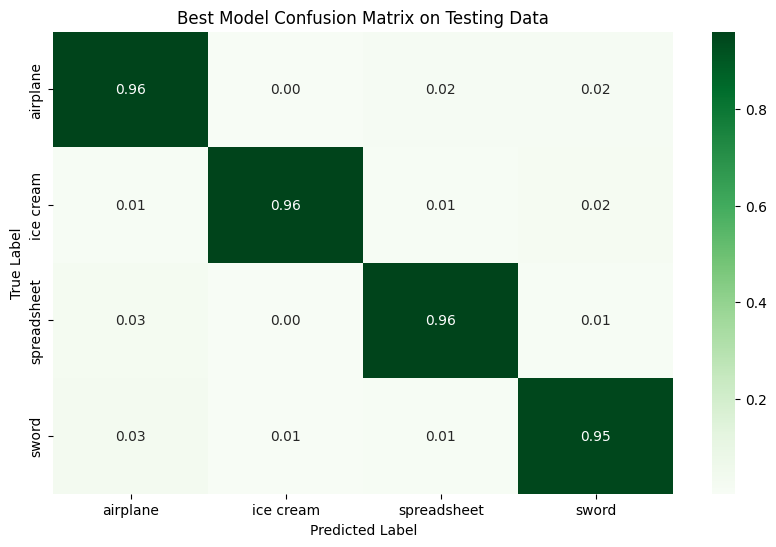

In [51]:
# Compute cm
cm = confusion_matrix(y_test, y_test_pred, normalize="true")

# Decode labels
class_names = list(label2idx.keys())

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=class_names,yticklabels=class_names)

plt.title("Best Model Confusion Matrix on Testing Data")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig("../output/Final_Model_ConfusionMatrix.png")
plt.show()


### Only 4.21% of the images were misclassified! Here are some of those misclassified images:  

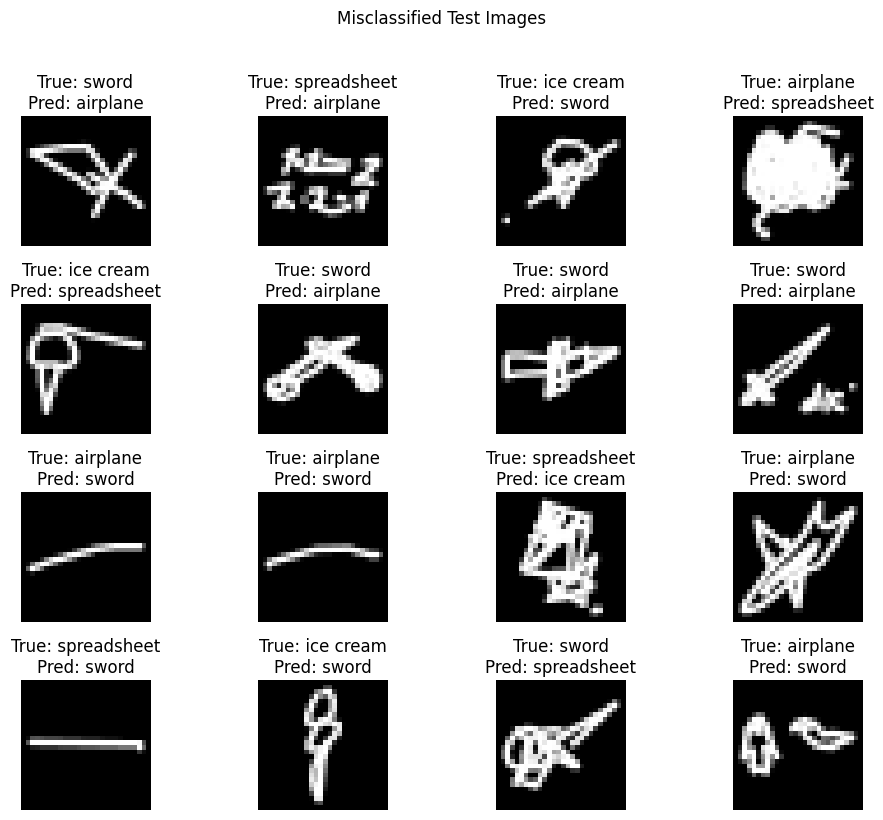

In [50]:
y_test_decoded = np.array([class_names[i] for i in y_test])
y_pred_decoded = np.array([class_names[i] for i in y_test_pred])

incorrect_idx = (y_test_decoded != y_pred_decoded)

wrong_images = X_test[incorrect_idx][:16]
wrong_true = y_test_decoded[incorrect_idx][:16]
wrong_pred = y_pred_decoded[incorrect_idx][:16]

plt.figure(figsize=(10, 8))
for i in range(len(wrong_images)):
    plt.subplot(4, 4, i+1)
    plt.imshow(wrong_images[i].reshape(28, 28), cmap="gray") 
    plt.title(f"True: {wrong_true[i]}\nPred: {wrong_pred[i]}", fontsize=12)
    plt.axis("off")

plt.suptitle("Misclassified Test Images", y=1.02)
plt.tight_layout()
plt.show()


##### Overall, our model definitely learned how to classify hand-drawn doodles. Some of these mistakes are even ambiguous to a human.